<a href="https://colab.research.google.com/github/micahming/lus-preds/blob/main/EMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT

In [ ]:

from glob import glob
from datetime import datetime
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px
import pytz
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

# READ

In [ ]:
def wrangle(filepath):

    df =pd.read_excel(filepath)
    #Create timestamp
    file_name = f" {filepath} "
    file_name = file_name.replace(".xlsx.xls","").replace("/content/LUSE_STOCK/","").replace(" ","")
    formalt= '%Y-%m-%d'
    timestamp = datetime.strptime(file_name,formalt)


    #Adding Column Names
    column_row_1 = list(df.iloc[8])
    column_row_2=[str(item) for item in (list(df.iloc[9]))]
    column_row_3=[str(item) for item in (list(df.iloc[10]))]

    column_names=[]
    count = 0
    for name in column_row_1:
        freshname=column_row_1[count] + column_row_2[count]+ column_row_3[count]
        new = freshname.replace("nan","",2)
        column_names.append(new)
        count=count+1

    df.columns = column_names




    #Create StringCheck

    string_check = ['AELZ', 'ATEL', 'BATA', 'BATZ', 'CCHZ', 'CECZ', 'FARM', 'FQMZ',
           'INVE', 'LAFA', 'MAFS', 'NATB', 'PMDZ', 'PRIM', 'PUMA', 'REIZ',
           'SCBL', 'SHOP', 'ZABR', 'ZCCM', 'ZMBF', 'ZMFA', 'ZNCO', 'ZSUG']

    pattern = '|'.join(string_check)
    #Apply mask to only show companies
    cleaner=df['Instrument'].str.contains(pattern).fillna(False)
    df = df[cleaner]
    #Fill NaN Values
    df=df.fillna(0)

    #Filter for select companies
    select_companies = ['CECZ','ATEL','REIZ','SCBL','SHOP']
    string_check2 = "|".join(select_companies)
    df=df[df['Instrument'].str.contains(string_check2)]

    #Add DataFrame Date
    df['timestamp'] = [timestamp] * 5

   #Drop Columns
    # df= df.drop(columns=[ 'Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
    #    'LastTradePrice', 'NetChange', 'TotalTurnover',
    #    'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
    #    'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
    #    'TotalVolume', 'ForeignSells'], inplace =True)



    return df

In [ ]:
files = sorted(glob("/content/LUSE_STOCK/*-*-*.xlsx.xls"))


In [ ]:
frames = [wrangle(file) for file in files]



<ipython-input-54-34b4bdbd57c5>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = [timestamp] * 5


In [ ]:
atel_frames=[(frame[frame['Instrument']=='ATEL']) for frame in frames]
cecz_frames=[(frame[frame['Instrument']=='CECZ']) for frame in frames]
reiz_frames=[(frame[frame['Instrument']=='REIZ']) for frame in frames]
scbl_frames=[(frame[frame['Instrument']=='SCBL']) for frame in frames]
shop_frames=[(frame[frame['Instrument']=='SHOP']) for frame in frames]

In [ ]:
final_atel_frame= pd.concat(atel_frames).fillna(0)
final_cecz_frame= pd.concat(cecz_frames).fillna(0)
final_reiz_frame= pd.concat(reiz_frames).fillna(0)
final_scbl_frame= pd.concat(scbl_frames).fillna(0)
final_shop_frame= pd.concat(shop_frames).fillna(0)

In [ ]:
final_scbl_frame.head(100)

,Instrument,Bid Qty,BidPrice,AskPrice,Ask Qty,LastTradePrice,NetChange,ClosingPrice,TotalTurnover,AveragePrice,...,52 WeekLow,OpeningPrice,Change%,PrevClosingPrice,TotalTrades,TotalVolume,ForeignBuys,ForeignSells,timestamp,ForeignBuy
27,SCBL,0,0.0,1.63,13500,1.63,0.0,1.63,1305.63,1.63,...,1.63,1.63,0.0,1.63,3,801,0,0,2020-01-02,0.0
27,SCBL,0,0.0,1.63,13500,0.00,0.0,1.63,0.00,0.00,...,1.63,1.63,0.0,1.63,0,0,0,0,2020-01-03,0.0
27,SCBL,0,0.0,1.63,13500,0.00,0.0,1.63,0.00,0.00,...,1.63,1.63,0.0,1.63,0,0,0,0,2020-01-06,0.0
27,SCBL,0,0.0,1.63,17400,1.63,0.0,1.63,971.48,1.63,...,1.63,1.63,0.0,1.63,9,596,0,0,2020-01-07,0.0
27,SCBL,0,0.0,1.63,17400,0.00,0.0,1.63,0.00,0.00,...,1.63,1.63,0.0,1.63,0,0,0,0,2020-01-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,SCBL,0,0.0,1.50,59066,0.00,0.0,1.50,0.00,0.00,...,1.50,1.50,0.0,1.50,0,0,0,0,2020-05-21,0.0
27,SCBL,0,0.0,1.50,59066,0.00,0.0,1.50,0.00,0.00,...,1.50,1.50,0.0,1.50,0,0,0,0,2020-05-22,0.0
27,SCBL,0,0.0,1.50,59066,0.00,0.0,1.50,0.00,0.00,...,1.50,1.50,0.0,1.50,0,0,0,0,2020-05-26,0.0
27,SCBL,0,0.0,1.50,59066,0.00,0.0,1.50,0.00,0.00,...,1.50,1.50,0.0,1.50,0,0,0,0,2020-05-27,0.0


In [ ]:
final_atel_frame=final_atel_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_cecz_frame=final_cecz_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_reiz_frame=final_reiz_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_scbl_frame=final_scbl_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])
final_shop_frame=final_shop_frame.drop(columns=['Bid Qty', 'BidPrice', 'AskPrice', 'Ask Qty',
       'LastTradePrice', 'NetChange','TotalTurnover',
       'AveragePrice', 'LastTradedSize', '52 WeekHigh', '52 WeekLow',
       'OpeningPrice', 'Change%', 'PrevClosingPrice', 'TotalTrades',
       'TotalVolume', 'ForeignBuys', 'ForeignSells','ForeignBuy'])

In [ ]:
atel_time_series=final_atel_frame.set_index('timestamp').drop(columns='Instrument')
cecz_time_series=final_cecz_frame.set_index('timestamp').drop(columns='Instrument')
reiz_time_series=final_reiz_frame.set_index('timestamp').drop(columns='Instrument')
scbl_time_series=final_scbl_frame.set_index('timestamp').drop(columns='Instrument')
shop_time_series=final_shop_frame.set_index('timestamp').drop(columns='Instrument')

In [ ]:
aligned_atel= atel_time_series.asfreq('b').fillna(method='ffill')
aligned_cecz= cecz_time_series.asfreq('b').fillna(method='ffill')
aligned_reiz= reiz_time_series.asfreq('b').fillna(method='ffill')
aligned_scbl= scbl_time_series.asfreq('b').fillna(method='ffill')
aligned_shop= shop_time_series.asfreq('b').fillna(method='ffill')

In [ ]:
aligned_atel.info()
aligned_atel.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1075 entries, 2020-01-02 to 2024-02-14
Freq: B
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ClosingPrice  1075 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


,ClosingPrice
timestamp,
2020-01-02,31.48
2020-01-03,31.48
2020-01-06,31.48
2020-01-07,31.48
2020-01-08,31.48


# ATEL MODEL

## SPLIT

In [ ]:
train_atel = aligned_atel[:-30]
test_atel = aligned_atel[-30:]

## BUILD MODEL

In [ ]:
model_atel = ExponentialSmoothing(train_atel).fit()

## EVALUATE

In [ ]:
pred_atel = model_atel.forecast(steps = 30)

In [ ]:
test_atel['Predictions'] = pred_atel

<ipython-input-67-e33764ab5fdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_atel['Predictions'] = pred_atel


<Axes: xlabel='timestamp'>

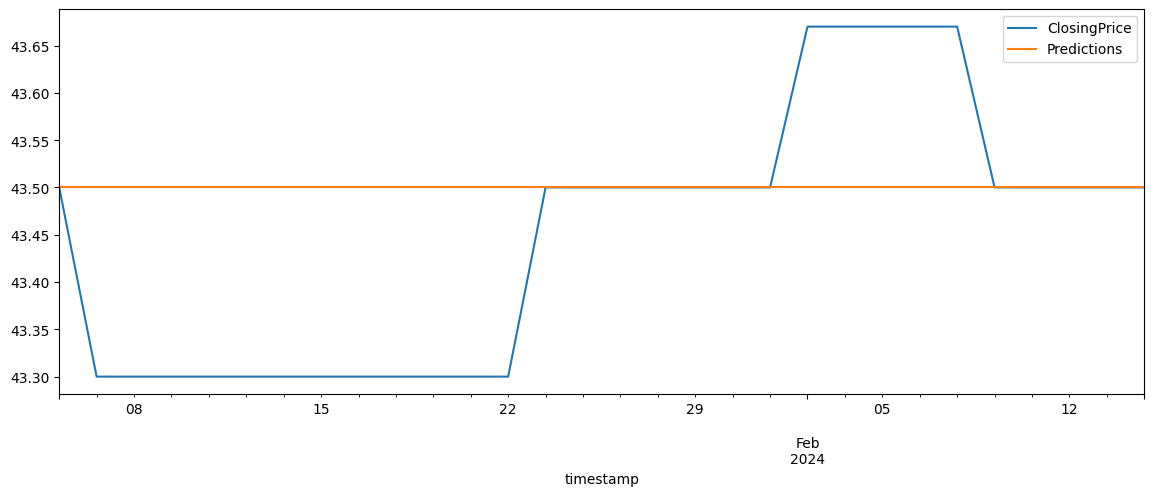

In [ ]:
test_atel.plot(figsize=(14,5))

In [ ]:
y_pred_baseline_atel = [(train_atel.mean())]*len(train_atel)
mae_baseline_atel = mean_absolute_error(train_atel,y_pred_baseline_atel)


print("Baseline MAE:", round(mae_baseline_atel, 2))

Baseline MAE: 6.7


In [ ]:
test_atel['ClosingPrice'].mean()
rmse_atel=sqrt(mean_squared_error(pred_atel,test_atel['ClosingPrice']))
mae_atel=mean_absolute_error(pred_atel,test_atel['ClosingPrice'])
print(f"Test RMSE: {rmse_atel}" ,f"Test MAE: {mae_atel}" )

Test RMSE: 0.1442798207188629 Test MAE: 0.10833333333333475


# CECZ MODEL

## SPLIT

In [ ]:
train_cecz = aligned_cecz[:-30]
test_cecz = aligned_cecz[-30:]

## BUILD MODEL

In [ ]:
model_cecz = ExponentialSmoothing(train_cecz).fit()

## EVALUATE

In [ ]:
pred_cecz = model_cecz.forecast(steps = 30)

In [ ]:
test_cecz['Predictions'] = pred_cecz

<ipython-input-74-9e3cb71421b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cecz['Predictions'] = pred_cecz


<Axes: xlabel='timestamp'>

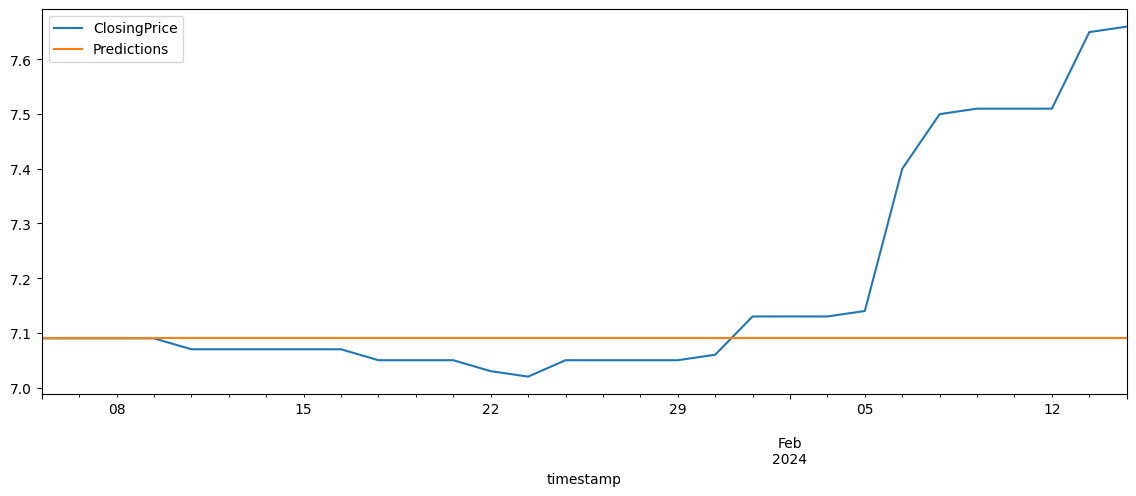

In [ ]:
test_cecz.plot(figsize=(14,5))

In [ ]:
y_pred_baseline_cecz = [(train_cecz.mean())]*len(train_cecz)
mae_baseline_cecz = mean_absolute_error(train_cecz,y_pred_baseline_cecz)


print("Baseline MAE:", round(mae_baseline_cecz, 2))

Baseline MAE: 1.61


In [ ]:
test_cecz['ClosingPrice'].mean()
rmse_cecz=sqrt(mean_squared_error(pred_atel,test_cecz['ClosingPrice']))
mae_cecz=mean_absolute_error(pred_atel,test_cecz['ClosingPrice'])
print(f"Test RMSE: {rmse_cecz}" ,f"Test MAE: {mae_cecz}" )

Test RMSE: 36.31922264219506 Test MAE: 36.318666666666665


# REIZ MODEL

## SPLIT

In [ ]:
train_reiz = aligned_reiz[:-30]
test_reiz = aligned_reiz[-30:]

## BUILD MODEL

In [ ]:
model_reiz = ExponentialSmoothing(train_reiz).fit()

## EVALUATE

In [ ]:
pred_reiz = model_reiz.forecast(steps = 30)

In [ ]:
test_reiz['Predictions'] = pred_reiz

<ipython-input-81-269c7cd7b2bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_reiz['Predictions'] = pred_reiz


<Axes: xlabel='timestamp'>

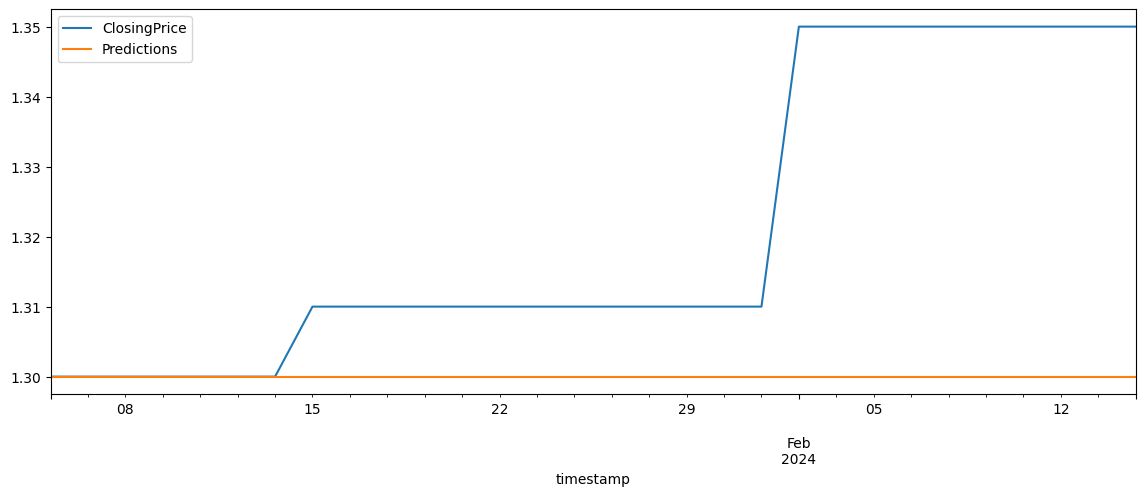

In [ ]:
test_reiz.plot(figsize=(14,5))

In [ ]:
y_pred_baseline_reiz = [(train_reiz.mean())]*len(train_reiz)
mae_baseline_reiz = mean_absolute_error(train_reiz,y_pred_baseline_reiz)


print("Baseline MAE:", round(mae_baseline_reiz, 2))

Baseline MAE: 0.88


In [ ]:
test_reiz['ClosingPrice'].mean()
rmse_reiz=sqrt(mean_squared_error(pred_reiz,test_reiz['ClosingPrice']))
mae_reiz=mean_absolute_error(pred_reiz,test_reiz['ClosingPrice'])
print(f"Test RMSE: {rmse_reiz}" ,f"Test MAE: {mae_reiz}" )

Test RMSE: 0.0296085573216033 Test MAE: 0.02100000000000002


# SCBL MODEL

## SPLIT

In [ ]:
train_scbl = aligned_scbl[:-30]
test_scbl = aligned_scbl[-30:]

## BUILD MODEL

In [ ]:
model_scbl = ExponentialSmoothing(train_scbl).fit()

## EVALUATE

In [ ]:
pred_scbl = model_scbl.forecast(steps = 30)

In [ ]:
test_scbl['Predictions'] = pred_scbl

<ipython-input-88-739387e37cf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_scbl['Predictions'] = pred_scbl


<Axes: xlabel='timestamp'>

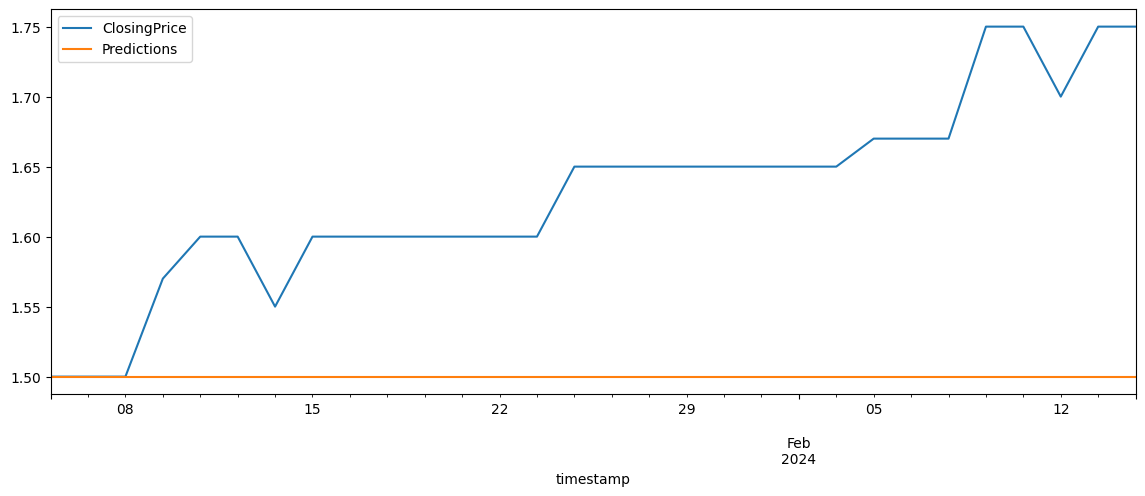

In [ ]:
test_scbl.plot(figsize=(14,5))

In [ ]:
y_pred_baseline_scbl = [(train_scbl.mean())]*len(train_scbl)
mae_baseline_scbl = mean_absolute_error(train_scbl,y_pred_baseline_scbl)


print("Baseline MAE:", round(mae_baseline_scbl, 2))

Baseline MAE: 0.13


In [ ]:
test_scbl['ClosingPrice'].mean()
rmse_scbl=sqrt(mean_squared_error(pred_scbl,test_scbl['ClosingPrice']))
mae_scbl=mean_absolute_error(pred_scbl,test_scbl['ClosingPrice'])
print(f"Test RMSE: {rmse_scbl}" ,f"Test MAE: {mae_scbl}" )

Test RMSE: 0.14765951826188967 Test MAE: 0.13099999999999998


# SHOP MODEL

## SPLIT

In [ ]:
train_shop = aligned_shop[:-30]
test_shop = aligned_shop[-30:]

## BUILD MODEL

In [ ]:
model_shop = ExponentialSmoothing(train_shop).fit()

## EVALUATE

In [ ]:
pred_shop = model_shop.forecast(steps = 30)

In [ ]:
test_shop['Predictions'] = pred_shop

<ipython-input-95-30a50c9f0ca0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_shop['Predictions'] = pred_shop


<Axes: xlabel='timestamp'>

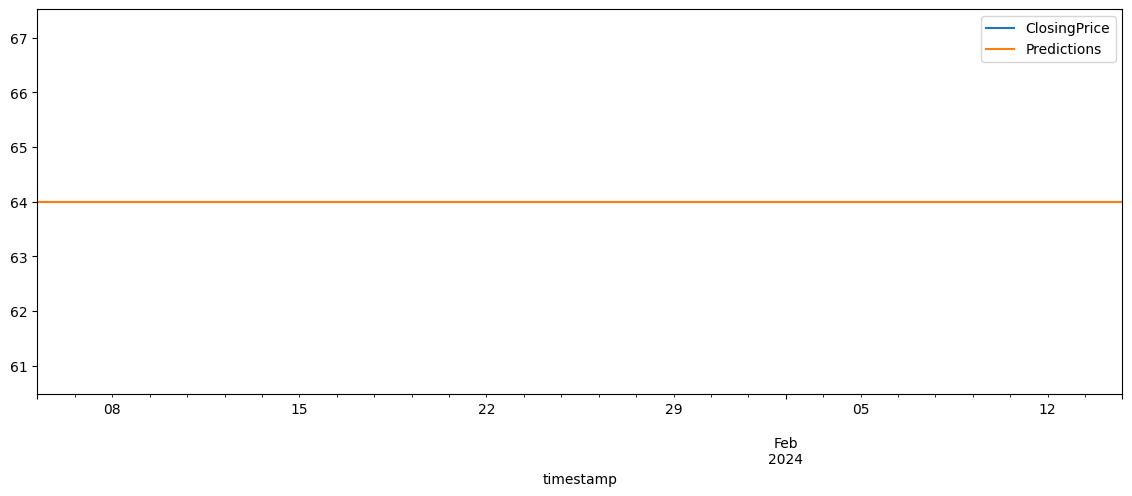

In [ ]:
test_shop.plot(figsize=(14,5))

In [ ]:
y_pred_baseline_shop = [(train_shop.mean())]*len(train_shop)
mae_baseline_shop = mean_absolute_error(train_shop,y_pred_baseline_shop)


print("Baseline MAE:", round(mae_baseline_shop, 2))

Baseline MAE: 0.47


In [ ]:
test_shop['ClosingPrice'].mean()
rmse_shop=sqrt(mean_squared_error(pred_shop,test_shop['ClosingPrice']))
mae_shop=mean_absolute_error(pred_shop,test_shop['ClosingPrice'])
print(f"Test RMSE: {rmse_shop}" ,f"Test MAE: {mae_shop}" )

Test RMSE: 0.0 Test MAE: 0.0
